In [25]:
pip install tensorflow matplotlib

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Path to the unzipped dataset folder
dataset_path = '/content/drive/MyDrive/wordlevelDataset/'
# Example: listing subfolders or files
import os

classes = os.listdir(dataset_path)
print("Classes found:", classes)

Classes found: ['Dhanyabaad', 'Ghar', 'Ma', 'Namaskaar']


In [31]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# ------------------- Step 1: Define Paths -------------------
original_dataset_dir = '/content/drive/MyDrive/wordlevelDataset'  # Unzipped dataset with class folders
base_dir = '/content/drive/MyDrive/wordDataset'  # Folder to save split data

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# ------------------- Step 2: Create Directory Structure -------------------
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

# ------------------- Step 3: Split Each Class -------------------
classes = os.listdir(original_dataset_dir)

for class_name in classes:
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip if not a folder

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Shuffle and split into 70% train, 20% val, 10% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.30, random_state=42)  # 70% train
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=1/3, random_state=42)  # 20% val, 10% test

    # Create class subdirectories
    for split_dir, split_imgs in zip(
        [train_dir, val_dir, test_dir],
        [train_imgs, val_imgs, test_imgs]
    ):
        class_split_dir = os.path.join(split_dir, class_name)
        os.makedirs(class_split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(class_split_dir, img))

print(" Dataset successfully split into Train (70%), Validation (20%), Test (10%)")


 Dataset successfully split into Train (70%), Validation (20%), Test (10%)


In [32]:
# ------------------- Step 4: Prepare Data Generators -------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height = 128
img_width = 128
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_data.class_indices.keys())
print("Class labels:", class_names)

Found 9779 images belonging to 4 classes.
Found 2793 images belonging to 4 classes.
Found 1399 images belonging to 4 classes.
Class labels: ['Dhanyabaad', 'Ghar', 'Ma', 'Namaskaar']


In [ ]:
import os
from PIL import Image

def clean_dataset(directory):
    for root, dirs, files in os.walk(directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            try:
                # Try opening the image
                with Image.open(file_path) as img:
                    img.verify()  # Verify it’s a proper image
            except Exception as e:
                print(f"❌ Removing corrupted file: {file_path}")
                os.remove(file_path)

# Use it on your dataset
clean_dataset('/content/drive/MyDrive/wordDataset')


In [33]:
from tensorflow.keras import layers, models, callbacks

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting

    layers.Dense(4, activation='softmax')  # 36 classes for Nepali characters
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
# EarlyStopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [36]:
# Train the model with early stopping
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 77s 196ms/step - accuracy: 0.5981 - loss: 0.9369 - val_accuracy: 0.9381 - val_loss: 0.1728
Epoch 2/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 52s 151ms/step - accuracy: 0.9393 - loss: 0.1679 - val_accuracy: 0.9742 - val_loss: 0.0797
Epoch 3/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - accuracy: 0.9698 - loss: 0.0915 - val_accuracy: 0.9875 - val_loss: 0.0408
Epoch 4/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - accuracy: 0.9780 - loss: 0.0630 - val_accuracy: 0.9914 - val_loss: 0.0346
Epoch 5/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.9851 - loss: 0.0470 - val_accuracy: 0.9932 - val_loss: 0.0280
Epoch 6/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 82s 145ms/step - accuracy: 0.9880 - loss: 0.0364 - val_accuracy: 0.9907 - val_loss: 0.0373
Epoch 7/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 44s 144ms/step - accuracy: 0.9879 - loss: 0.0307 - val_accuracy: 0.9950 - val_loss: 0.0242
Epoch 8/50
306/306 ━━━━━━━━━━━━━━━━━━━━ 45s 147ms/step - accuracy: 0.9883 - loss: 0

In [37]:
# STEP 6: Save the Model
model.save('/content/drive/MyDrive/Wordlevel_model.h5')

In [38]:
print(train_data.class_indices)

{'Dhanyabaad': 0, 'Ghar': 1, 'Ma': 2, 'Namaskaar': 3}


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

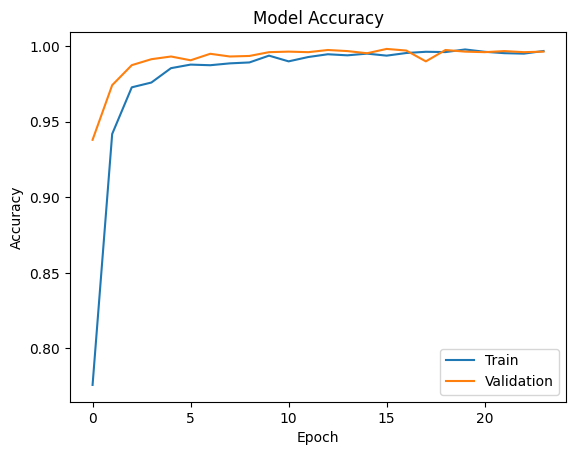

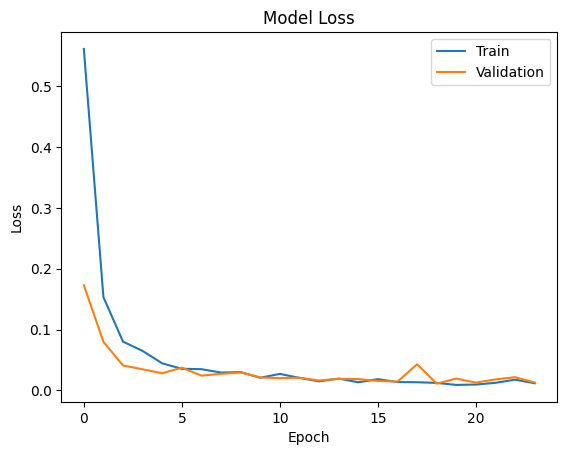

In [40]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
Classification Report:
               precision    recall  f1-score   support

  Dhanyabaad       0.99      1.00      0.99       350
        Ghar       1.00      0.99      0.99       349
          Ma       1.00      1.00      1.00       349
   Namaskaar       0.99      1.00      1.00       351

    accuracy                           1.00      1399
   macro avg       1.00      1.00      1.00      1399
weighted avg       1.00      1.00      1.00      1399



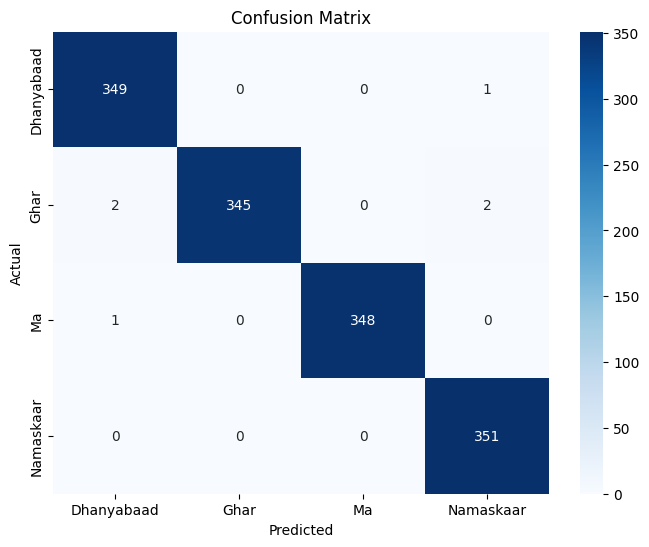

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()